In [56]:
import pandas as pd 
import timeseries as ts
from pandas import DataFrame
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

In [57]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 #if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [58]:

sarima0000107 = ts.TimeSeries((0, 0, 0), (0, 1, 0, 7))

df = sarima0000107.train_data.to_numpy()
test_df = sarima0000107.test_data.to_numpy()

Fecha
2017-01-01      123704
2017-01-02    21209771
2017-01-03    26706072
2017-01-04    29734324
2017-01-05    58392417
Name: Ventas, dtype: int64
Model Fitting Time: 0.033911943435668945
                                SARIMAX Results                                
Dep. Variable:                  Ventas   No. Observations:                  912
Model:             SARIMAX(0, 1, 0, 7)   Log Likelihood                1150.048
Date:                 Tue, 01 Dec 2020   AIC                          -2298.096
Time:                         16:16:18   BIC                          -2293.289
Sample:                     01-01-2017   HQIC                         -2296.260
                          - 07-01-2019                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       

In [59]:
train = series_to_supervised(df, n_out = 1)
test = series_to_supervised(test_df, n_out = 1)



(array([[0.        , 0.02744956],
        [0.02744956, 0.03460457],
        [0.03460457, 0.03854671],
        ...,
        [1.        , 0.43626184],
        [0.43626184, 0.35248997],
        [0.35248997, 0.14174155]]),
 array([[0.19764994, 0.26073126],
        [0.26073126, 0.30617245],
        [0.30617245, 0.63083616],
        [0.63083616, 0.53135031],
        [0.53135031, 0.25789907],
        [0.25789907, 0.13335829],
        [0.13335829, 0.17564766],
        [0.17564766, 0.25075758],
        [0.25075758, 0.33196168],
        [0.33196168, 0.69596812],
        [0.69596812, 0.47921984],
        [0.47921984, 0.18055597],
        [0.18055597, 0.13944221],
        [0.13944221, 0.1968298 ],
        [0.1968298 , 0.24449764],
        [0.24449764, 0.33723561],
        [0.33723561, 0.70884891],
        [0.70884891, 0.43882241],
        [0.43882241, 0.15529346],
        [0.15529346, 0.13284472],
        [0.13284472, 0.17009935],
        [0.17009935, 0.22543975],
        [0.22543975, 0.30485323],

In [62]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, estimators = 1000):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, estimators = 1000):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=0.0, predicted=0.2
>expected=0.0, predicted=0.0
>expected=0.1, predicted=0.1
>expected=0.1, predicted=0.2
>expected=0.2, predicted=0.2
>expected=0.1, predicted=0.1
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.1
>expected=0.0, predicted=0.0
>expected=0.1, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.2, predicted=0.2
>expected=0.1, predicted=0.1
>expected=0.0, predicted=0.1
>expected=0.0, predicted=0.0
>expected=0.0, predicted=0.1
>expected=0.2, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.2, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.0, predicted=0.1
>expected=0.0, predicted=0.1
>expected=0.0, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.1, predicted=0.2
>expected=0.2, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.0, predicted=0.1
>expected=0.0, predicted=0.0
>expected=0.1, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.2, predicted=0.1
>expected=0.1, predicted=0.1
>expected=0.1,

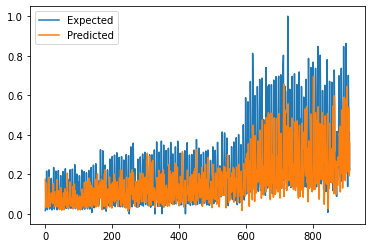

In [68]:
data = np.concatenate((train, test))
# evaluate
mae, y, yhat = walk_forward_validation(data, len(train))
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [ ]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX, estimators = 1000):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=estimators)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation7(data, n_test, estimators = 1000):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions


# evaluate
mae7, y7, yhat7 = walk_forward_validation7(data, len(train))
print('MAE: %.3f' % mae7)
# plot expected vs predicted
pyplot.plot(y7, label='Expected')
pyplot.plot(yhat7, label='Predicted')
pyplot.legend()
pyplot.show()

In [69]:
data

array([[0.        , 0.02744956],
       [0.02744956, 0.03460457],
       [0.03460457, 0.03854671],
       ...,
       [0.54433468, 0.29565135],
       [0.29565135, 0.4153761 ],
       [0.4153761 , 0.22095027]])